# 02 — EDA & CAR Baseline

**Goal:** Before any ML, visually confirm that PEAD exists in our dataset.
If the raw signal isn't visible here, the model has nothing to learn.

**Key plots:**
1. SUE distribution by regime
2. Excess return by SUE quintile — the raw PEAD signal
3. Cumulative Abnormal Return (CAR) plots over 20 days post-earnings
4. Regime comparison: does PEAD behave differently in 2020–21 vs 2022–23?
5. Volume validation: does high volume confirm the move?

In [7]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

COLORS = {'low_rate': '#2196F3', 'high_rate': '#F44336',
          'beat': '#4CAF50',     'miss': '#FF5722'}

def get_price_data(ticker, start="2019-01-01", end=None):
    try:
        t = yf.Ticker(ticker)
        df = t.history(start=start, end=end, auto_adjust=True)
        if df.empty or len(df) < 60:
            return None
        df.index = pd.to_datetime(df.index)
        if df.index.tzinfo is not None:
            df.index = df.index.tz_convert('America/New_York').tz_localize(None)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        return df.sort_index()
    except Exception:
        return None

def get_spx_returns(start="2019-01-01", end=None):
    spx = get_price_data("^GSPC", start=start, end=end)
    if spx is None:
        return None
    spx['spx_ret'] = spx['close'].pct_change()
    return spx[['close', 'spx_ret']].rename(columns={'close': 'spx_close'})

def get_earnings_history(ticker):
    try:
        t = yf.Ticker(ticker)
        cal = t.get_earnings_dates(limit=40)
        if cal is None or cal.empty:
            return None
        cal = cal.copy()
        cal.index = pd.to_datetime(cal.index)
        if cal.index.tzinfo is not None:
            cal.index = cal.index.tz_convert('America/New_York').tz_localize(None)
        cal = cal.sort_index()
        cal = cal.rename(columns={
            'Reported EPS': 'eps_actual',
            'EPS Estimate':  'eps_est',
            'Surprise(%)':   'surprise_pct'
        })
        cal = cal.dropna(subset=['eps_actual'])
        cal['eps_surprise']     = cal['eps_actual'] - cal['eps_est']
        cal['eps_std']          = cal['eps_surprise'].rolling(4, min_periods=2).std().shift(1)
        cal['sue']              = (cal['eps_surprise'] / (cal['eps_std'].abs() + 1e-9)).clip(-10, 10)
        cal['eps_surprise_pct'] = cal['eps_surprise'] / cal['eps_est'].abs().replace(0, np.nan)
        cal['beat']             = (cal['eps_actual'] > cal['eps_est']).astype(int)
        cal['hist_beat_rate']   = cal['beat'].shift(1).rolling(4, min_periods=2).mean()
        def consec_streak(series):
            streaks, count = [], 0
            for v in series:
                count = count + 1 if v == 1 else 0
                streaks.append(count)
            return pd.Series(streaks, index=series.index)
        cal['beat_streak'] = consec_streak(cal['beat'].shift(1).fillna(0))
        return cal
    except Exception as e:
        print(f"Error {ticker}: {e}")
        return None

from utils.helpers import (
    get_macro_data, compute_technical_features,
    compute_ticker_history_features, compute_targets, compute_magnitude_class
)

print("✓ Patched functions loaded")

✓ Patched functions loaded


Loaded: 1611 events, 69 tickers
  ticker           earn_date                  sector  quarter  year  \
0      T 2019-01-30 06:00:00  Communication Services        1  2019   
1    TMO 2019-01-30 06:00:00             Health Care        1  2019   
2     BA 2019-01-30 07:00:00             Industrials        1  2019   

   target_binary  target_mag  stock_ret_5d  spx_ret_5d  excess_ret_5d  ...  \
0              0           1      0.006469    0.010173      -0.003704  ...   
1              0           1      0.008937    0.010173      -0.001237  ...   
2              1           2      0.060327    0.010173       0.050153  ...   

   pct_above_ma20  rvol_10d  rvol_20d  vol_ratio_5d  vol_ratio_1d   atr_pct  \
0       -0.031615  0.251433       NaN      1.213632      2.683467  0.018386   
1        0.044858  0.207244       NaN      0.828570      1.078878  0.018616   
2        0.105745  0.337200       NaN      1.274968      3.236688  0.023185   

   ticker_avg_abs_move  ticker_avg_move  ticker_move_

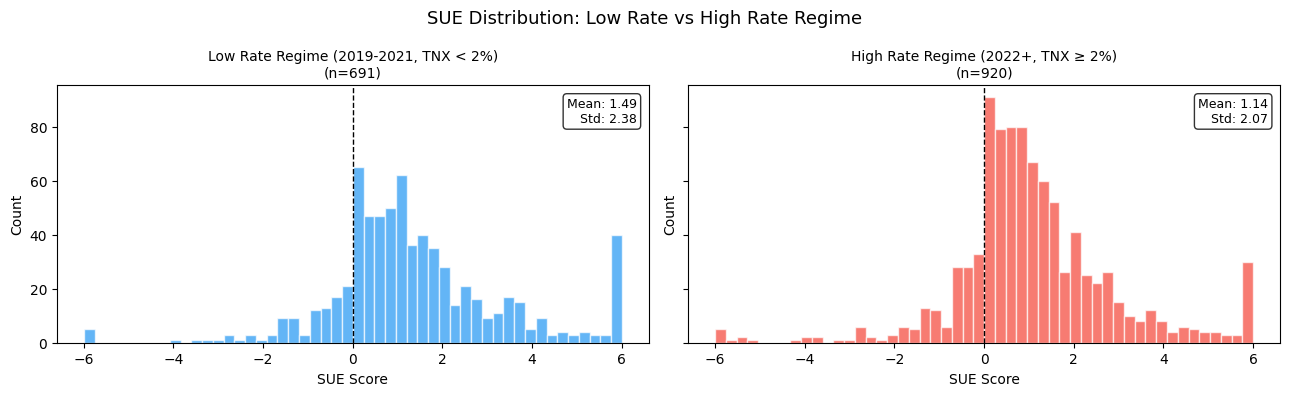

In [9]:
# ── Plot 1: SUE Distribution by Regime ───────────────────────


import matplotlib.pyplot as plt

panel = pd.read_csv('../data/panel_dataset.csv', parse_dates=['earn_date'])
panel = panel.sort_values('earn_date').reset_index(drop=True)
print(f'Loaded: {panel.shape[0]} events, {panel["ticker"].nunique()} tickers')
print(panel.head(3))


fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
fig.suptitle('SUE Distribution: Low Rate vs High Rate Regime', fontsize=13)

for ax, regime, label, color in zip(
    axes,
    [0, 1],
    ['Low Rate Regime (2019-2021, TNX < 2%)',
     'High Rate Regime (2022+, TNX ≥ 2%)'],
    [COLORS['low_rate'], COLORS['high_rate']]
):
    sub = panel[panel['rate_regime'] == regime]['sue'].dropna()
    ax.hist(sub.clip(-6, 6), bins=50, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'{label}\n(n={len(sub):,})', fontsize=10)
    ax.set_xlabel('SUE Score')
    ax.set_ylabel('Count')
    stats = f'Mean: {sub.mean():.2f}\nStd: {sub.std():.2f}'
    ax.text(0.98, 0.95, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../outputs/02_sue_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

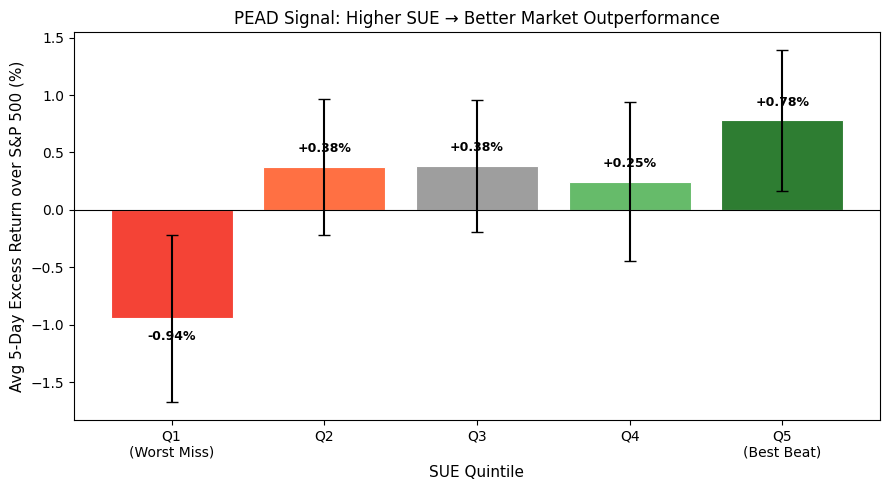

This chart is your anchor — if Q5 is meaningfully higher than Q1, PEAD exists in your data.


In [10]:
# ── Plot 2: PEAD Signal — Excess Return by SUE Quintile ───────
panel['sue_quintile'] = pd.qcut(
    panel['sue'].rank(method='first'),
    q=5, labels=['Q1\n(Worst Miss)', 'Q2', 'Q3', 'Q4', 'Q5\n(Best Beat)']
)

sue_stats = panel.groupby('sue_quintile', observed=True)['excess_ret_5d'].agg(
    mean='mean', sem=lambda x: x.std() / np.sqrt(len(x))
).reset_index()

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#F44336','#FF7043','#9E9E9E','#66BB6A','#2E7D32']
bars = ax.bar(
    sue_stats['sue_quintile'].astype(str),
    sue_stats['mean'] * 100,
    yerr=sue_stats['sem'] * 100 * 1.96,
    color=colors, edgecolor='white', linewidth=0.8,
    capsize=4, error_kw={'linewidth': 1.5}
)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel('SUE Quintile', fontsize=11)
ax.set_ylabel('Avg 5-Day Excess Return over S&P 500 (%)', fontsize=11)
ax.set_title('PEAD Signal: Higher SUE → Better Market Outperformance', fontsize=12)
for bar, val in zip(bars, sue_stats['mean'] * 100):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.1 * np.sign(val),
            f'{val:+.2f}%', ha='center', va='bottom' if val > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/02_pead_signal.png', dpi=150, bbox_inches='tight')
plt.show()
print('This chart is your anchor — if Q5 is meaningfully higher than Q1, PEAD exists in your data.')

Computing 20-day CAR curves (this may take a few minutes)...


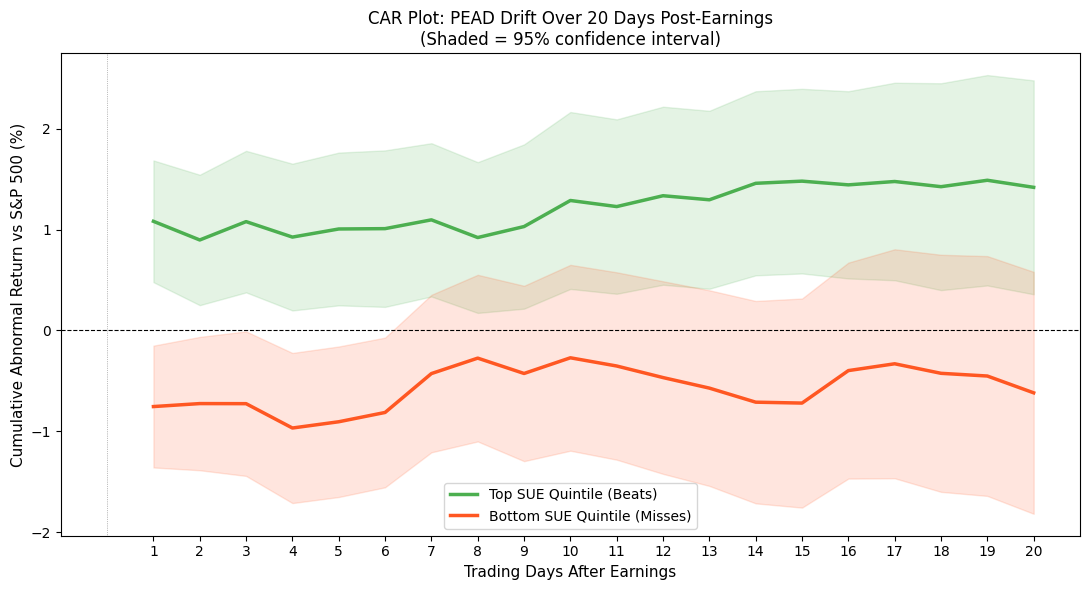

In [11]:
# ── Plot 3: Full CAR Plot — 20-Day Drift Post-Earnings ────────
# For this we need to recompute daily excess returns post-event

print('Computing 20-day CAR curves (this may take a few minutes)...')
spx = get_spx_returns(start='2019-01-01')

# Sample top/bottom SUE quintile events
beats = panel[panel['sue_quintile'] == 'Q5\n(Best Beat)'].head(200)
misses = panel[panel['sue_quintile'] == 'Q1\n(Worst Miss)'].head(200)

def compute_car_path(events_df, price_cache, spx_df, n_days=20):
    """Compute average CAR path across earnings events."""
    paths = []
    for _, row in events_df.iterrows():
        ticker    = row['ticker']
        earn_date = row['earn_date']

        price = price_cache.get(ticker)
        if price is None:
            price = get_price_data(ticker, start='2019-01-01')
            if price is None:
                continue
            price_cache[ticker] = price

        post_stock = price[price.index > earn_date].head(n_days)
        post_spx   = spx_df[spx_df.index > earn_date].head(n_days)

        if len(post_stock) < n_days or len(post_spx) < n_days:
            continue

        base_stock = price[price.index <= earn_date]
        if base_stock.empty:
            continue
        prev_close    = base_stock.iloc[-1]['close']
        prev_spx      = post_spx.iloc[0]['spx_close']

        stock_path = post_stock['close'].values / prev_close - 1
        spx_path   = post_spx['spx_close'].values / prev_spx - 1
        car_path   = stock_path - spx_path
        paths.append(car_path)

    if not paths:
        return np.zeros(n_days)
    arr = np.array(paths)
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0) / np.sqrt(len(arr))

price_cache = {}
beat_car, beat_se  = compute_car_path(beats,  price_cache, spx)
miss_car, miss_se  = compute_car_path(misses, price_cache, spx)

fig, ax = plt.subplots(figsize=(11, 6))
days = np.arange(1, len(beat_car) + 1)

ax.plot(days, beat_car * 100, color=COLORS['beat'], linewidth=2.5, label='Top SUE Quintile (Beats)')
ax.fill_between(days,
                (beat_car - 1.96*beat_se)*100,
                (beat_car + 1.96*beat_se)*100,
                alpha=0.15, color=COLORS['beat'])

ax.plot(days, miss_car * 100, color=COLORS['miss'], linewidth=2.5, label='Bottom SUE Quintile (Misses)')
ax.fill_between(days,
                (miss_car - 1.96*miss_se)*100,
                (miss_car + 1.96*miss_se)*100,
                alpha=0.15, color=COLORS['miss'])

ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.axvline(0, color='gray',  linewidth=0.5, linestyle=':')
ax.set_xlabel('Trading Days After Earnings', fontsize=11)
ax.set_ylabel('Cumulative Abnormal Return vs S&P 500 (%)', fontsize=11)
ax.set_title('CAR Plot: PEAD Drift Over 20 Days Post-Earnings\n(Shaded = 95% confidence interval)', fontsize=12)
ax.legend(fontsize=10)
ax.set_xticks(days)

plt.tight_layout()
plt.savefig('../outputs/02_car_plot.png', dpi=150, bbox_inches='tight')
plt.show()

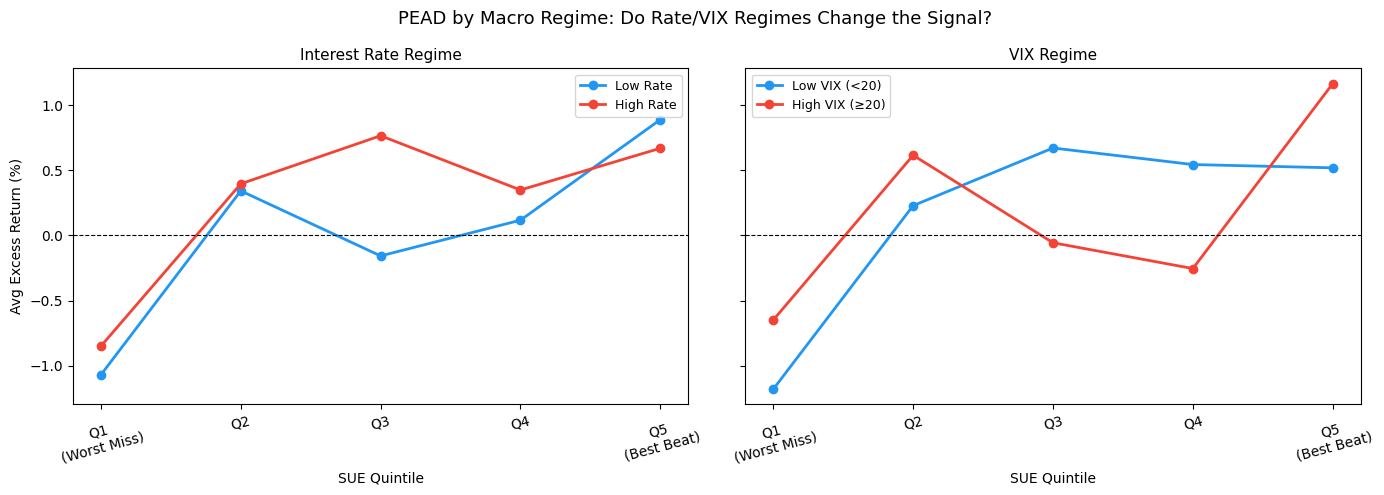


If the two lines diverge significantly, regimes matter for your model.


In [12]:
# ── Plot 4: Regime Comparison ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle('PEAD by Macro Regime: Do Rate/VIX Regimes Change the Signal?', fontsize=13)

for ax, regime_col, regime_labels, title in [
    (axes[0], 'rate_regime', {0: 'Low Rate', 1: 'High Rate'}, 'Interest Rate Regime'),
    (axes[1], 'vix_regime',  {0: 'Low VIX (<20)', 1: 'High VIX (≥20)'}, 'VIX Regime')
]:
    for regime_val, label in regime_labels.items():
        sub = panel[panel[regime_col] == regime_val]
        if sub.empty:
            continue
        sue_q_ret = sub.groupby('sue_quintile', observed=True)['excess_ret_5d'].mean() * 100
        ax.plot(sue_q_ret.index.astype(str), sue_q_ret.values,
                marker='o', linewidth=2, label=label,
                color=COLORS['low_rate'] if regime_val == 0 else COLORS['high_rate'])

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('SUE Quintile')
    ax.set_ylabel('Avg Excess Return (%)' if ax == axes[0] else '')
    ax.legend(fontsize=9)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../outputs/02_regime_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nIf the two lines diverge significantly, regimes matter for your model.')

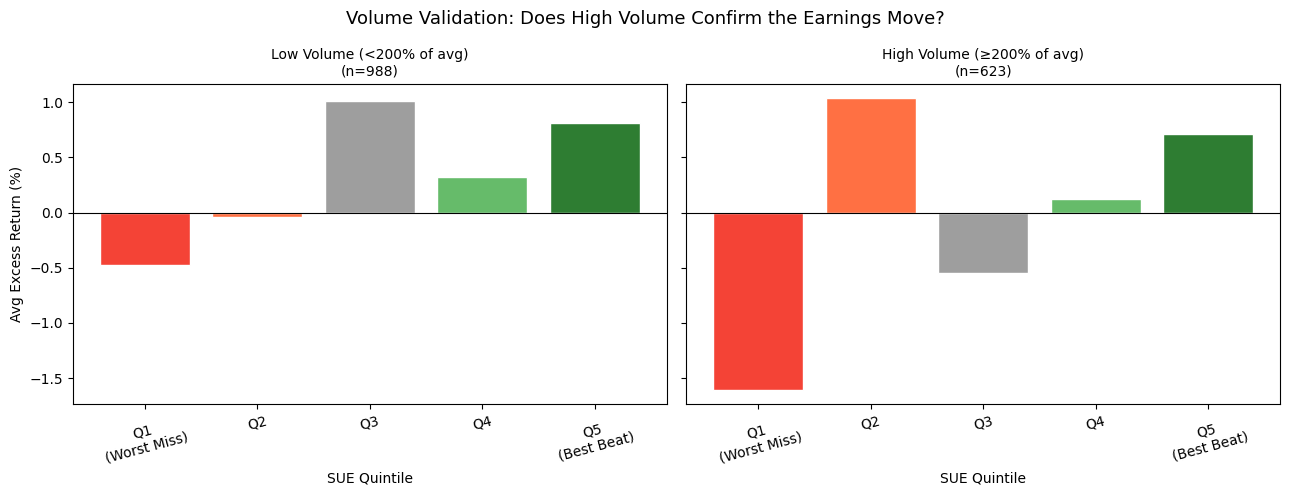

Hypothesis: High-volume beats should show stronger outperformance than low-volume beats.


In [13]:
# ── Plot 5: Volume Validation ─────────────────────────────────
# Does high-volume confirmation strengthen the signal?

# Split into high/low volume events
panel['vol_high'] = (panel['vol_ratio_1d'] > 2.0).astype(int)  # >200% of avg

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
fig.suptitle('Volume Validation: Does High Volume Confirm the Earnings Move?', fontsize=13)

for ax, vol_flag, label in [
    (axes[0], 0, 'Low Volume (<200% of avg)'),
    (axes[1], 1, 'High Volume (≥200% of avg)')
]:
    sub = panel[panel['vol_high'] == vol_flag]
    sue_q_ret = sub.groupby('sue_quintile', observed=True)['excess_ret_5d'].mean() * 100

    colors = ['#F44336','#FF7043','#9E9E9E','#66BB6A','#2E7D32']
    ax.bar(sue_q_ret.index.astype(str), sue_q_ret.values,
           color=colors, edgecolor='white')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f'{label}\n(n={len(sub):,})', fontsize=10)
    ax.set_xlabel('SUE Quintile')
    ax.tick_params(axis='x', rotation=15)

axes[0].set_ylabel('Avg Excess Return (%)')
plt.tight_layout()
plt.savefig('../outputs/02_volume_validation.png', dpi=150, bbox_inches='tight')
plt.show()
print('Hypothesis: High-volume beats should show stronger outperformance than low-volume beats.')

In [14]:
# ── Summary Stats Table ───────────────────────────────────────
print('=' * 60)
print('SUMMARY: Baseline PEAD Statistics')
print('=' * 60)

overall_outperform = panel['target_binary'].mean()
top_sue_outperform = panel[panel['sue_quintile'] == 'Q5\n(Best Beat)']['target_binary'].mean()
bot_sue_outperform = panel[panel['sue_quintile'] == 'Q1\n(Worst Miss)']['target_binary'].mean()

print(f'Overall outperform rate    : {overall_outperform:.1%}')
print(f'Top SUE quintile outperform: {top_sue_outperform:.1%}  ← should be > 50%')
print(f'Bot SUE quintile outperform: {bot_sue_outperform:.1%}  ← should be < 50%')
print(f'\nIf top > 50% and bottom < 50%, the PEAD signal is real in your data.')
print(f'The ML model will try to refine this beyond the simple SUE ranking.')

SUMMARY: Baseline PEAD Statistics
Overall outperform rate    : 49.2%
Top SUE quintile outperform: 54.7%  ← should be > 50%
Bot SUE quintile outperform: 44.0%  ← should be < 50%

If top > 50% and bottom < 50%, the PEAD signal is real in your data.
The ML model will try to refine this beyond the simple SUE ranking.
